# Time series of temp and salt in different regions

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/v45/akm157/figures/basal_melt_param/'

In [2]:
client = Client()
client

<Client: 'tcp://127.0.0.1:45289' processes=7 threads=28, memory=125.20 GiB>

In [3]:
master_session = cc.database.create_session()

control = '01deg_jra55v13_ryf9091'

#session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
session_name = '/g/data/v45/akm157/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

# temperature of meltwater using Gade line:
basal = 'accessom2-GPC015'

start_time='2150-01-01'
end_time='2165-12-31'

lat_slice  = slice(-80,-59)

In [4]:
# build database for these experiments:
#dir_list = ['/scratch/v45/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/',
#           '/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/accessom2-GPC015/accessom2-GPC015/',]
dir_list = ['/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/accessom2-GPC015/accessom2-GPC015/',]
cc.database.build_index(dir_list,basal_melt_session)

Indexing experiment: accessom2-GPC015


100%|██████████| 308/308 [02:20<00:00,  2.20it/s]


308

In [5]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

fontsize=15

## Maps of bottom temperature anomaly:

In [6]:
start_time='2150-01-01'
end_time='2165-12-31'

temp_con = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
temp_con = temp_con.mean('time').load()

start_time='2153-01-01'
end_time='2157-12-31'

temp_basal_53_57 = cc.querying.getvar(basal, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_basal_53_57 = temp_basal_53_57.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
temp_basal_53_57 = temp_basal_53_57.mean('time').load()

start_time='2163-01-01'
end_time='2165-12-31'

temp_basal_63_65 = cc.querying.getvar(basal, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_basal_63_65 = temp_basal_63_65.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
temp_basal_63_65 = temp_basal_63_65.mean('time').load()

In [7]:
# select out bottom values:

depth_array = temp_con * 0 + temp_con.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

bottom_temp_con = temp_con.where(depth_array.st_ocean >= max_depth)
bottom_temp_con = bottom_temp_con.sum(dim = 'st_ocean')
bottom_temp_con = bottom_temp_con.load()

bottom_temp_basal_53_57 = temp_basal_53_57.where(depth_array.st_ocean >= max_depth)
bottom_temp_basal_53_57 = bottom_temp_basal_53_57.sum(dim = 'st_ocean')
bottom_temp_basal_53_57 = bottom_temp_basal_53_57.load()

bottom_temp_basal_63_65 = temp_basal_63_65.where(depth_array.st_ocean >= max_depth)
bottom_temp_basal_63_65 = bottom_temp_basal_63_65.sum(dim = 'st_ocean')
bottom_temp_basal_63_65 = bottom_temp_basal_63_65.load()

## Load Schmidtko data

In [12]:
# this is actually ASBW despite the naming:
filepath = '/g/data/v45/rm2389/Schmidtko_Observations/AASW_Temp_Salt.nc'
Schmidtko_data = xr.open_dataset(filepath)
temp_Schmidtko = Schmidtko_data.CT
salt_Schmidtko = Schmidtko_data.AS

# concat observations onto model grid.
x = temp_Schmidtko.lon.values
x[x> 80] = x[x>80]-360
# replace lon coordinate values with these modified longitude values
temp_Schmidtko['lon'] = x
salt_Schmidtko['lon'] = x
# now concatenate temp and salinity so that it goes from -280 to 80 like access
temp_Schmidtko = xr.concat((temp_Schmidtko[:,321:], temp_Schmidtko[:,:321]), dim='lon')
salt_Schmidtko = xr.concat((salt_Schmidtko[:,321:], salt_Schmidtko[:,:321]), dim='lon')

In [13]:
# interpolate obs onto model grid:

def interp_obs(obs,model_lat,model_lon): 
    obs_new = obs.interp(lat = model_lat, lon = model_lon)
    return obs_new

temp_Schmidtko = interp_obs(temp_Schmidtko,temp_con.yt_ocean,temp_con.xt_ocean)
salt_Schmidtko = interp_obs(salt_Schmidtko,temp_con.yt_ocean,temp_con.xt_ocean)

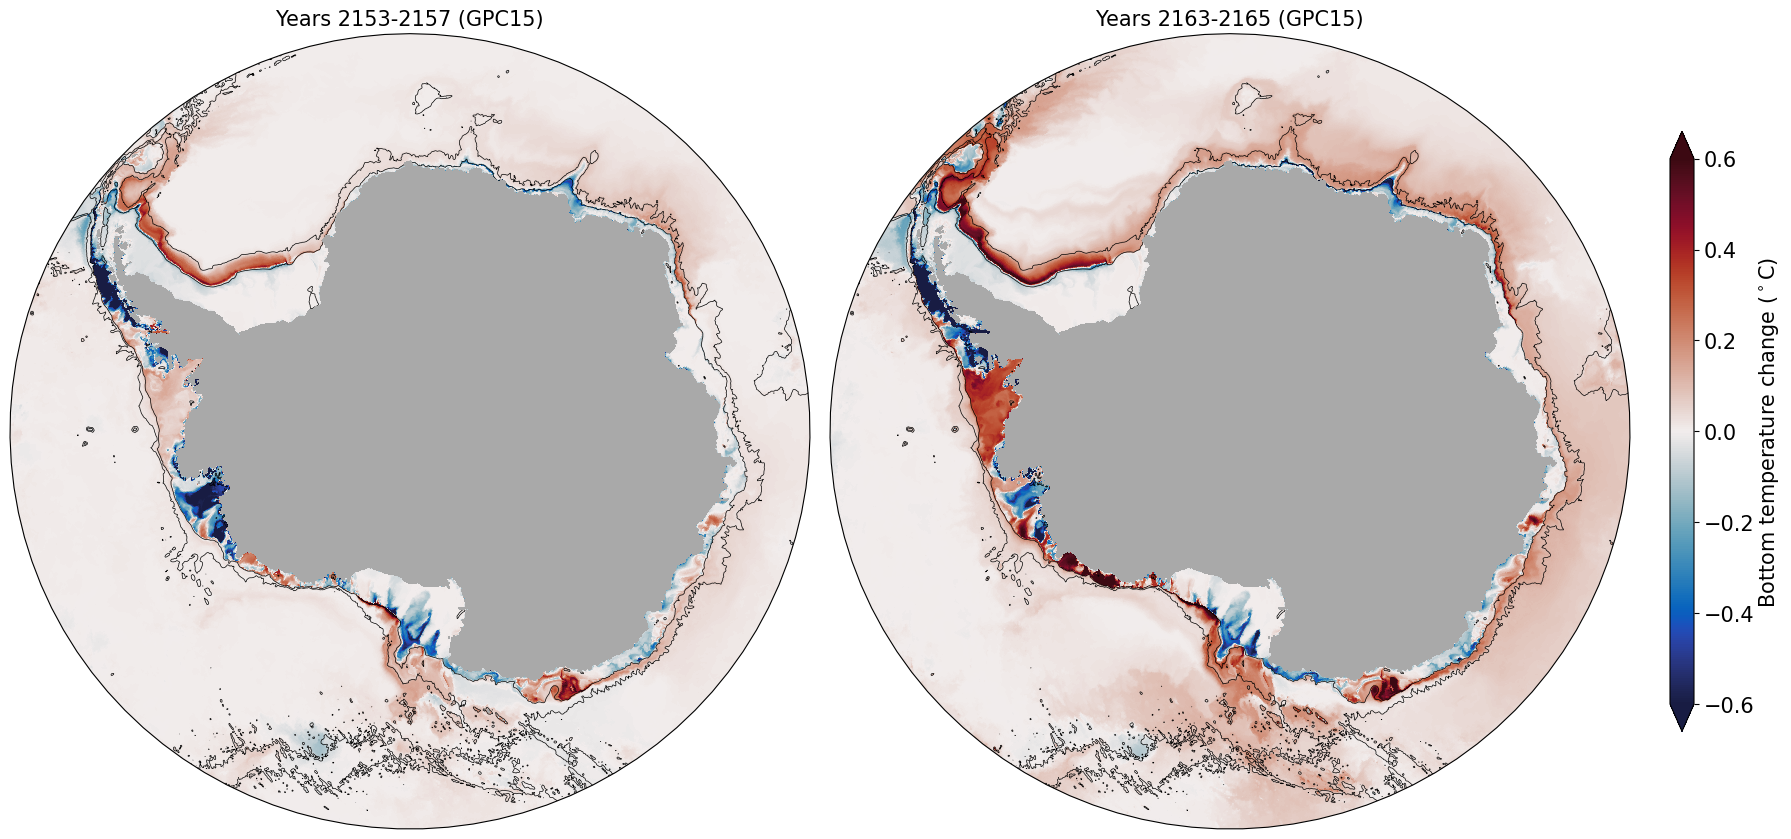

In [14]:
# compared to RYF:

scale_max = .6

fig  = plt.figure(1, figsize = (20,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# Tfreezing_insituS
# setup stereo projection:
ax = fig.add_axes([0.1, 0.0, 0.4, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, bottom_temp_basal_53_57-bottom_temp_con, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Years 2153-2157 (GPC15)',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Tfreezing_zeroS
ax = fig.add_axes([0.51, 0.0, 0.4, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, bottom_temp_basal_63_65-bottom_temp_con, norm = norm, 
                   cmap = cmocean.balance,transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Years 2163-2165 (GPC15)',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Bottom temperature change ($^\circ$C)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

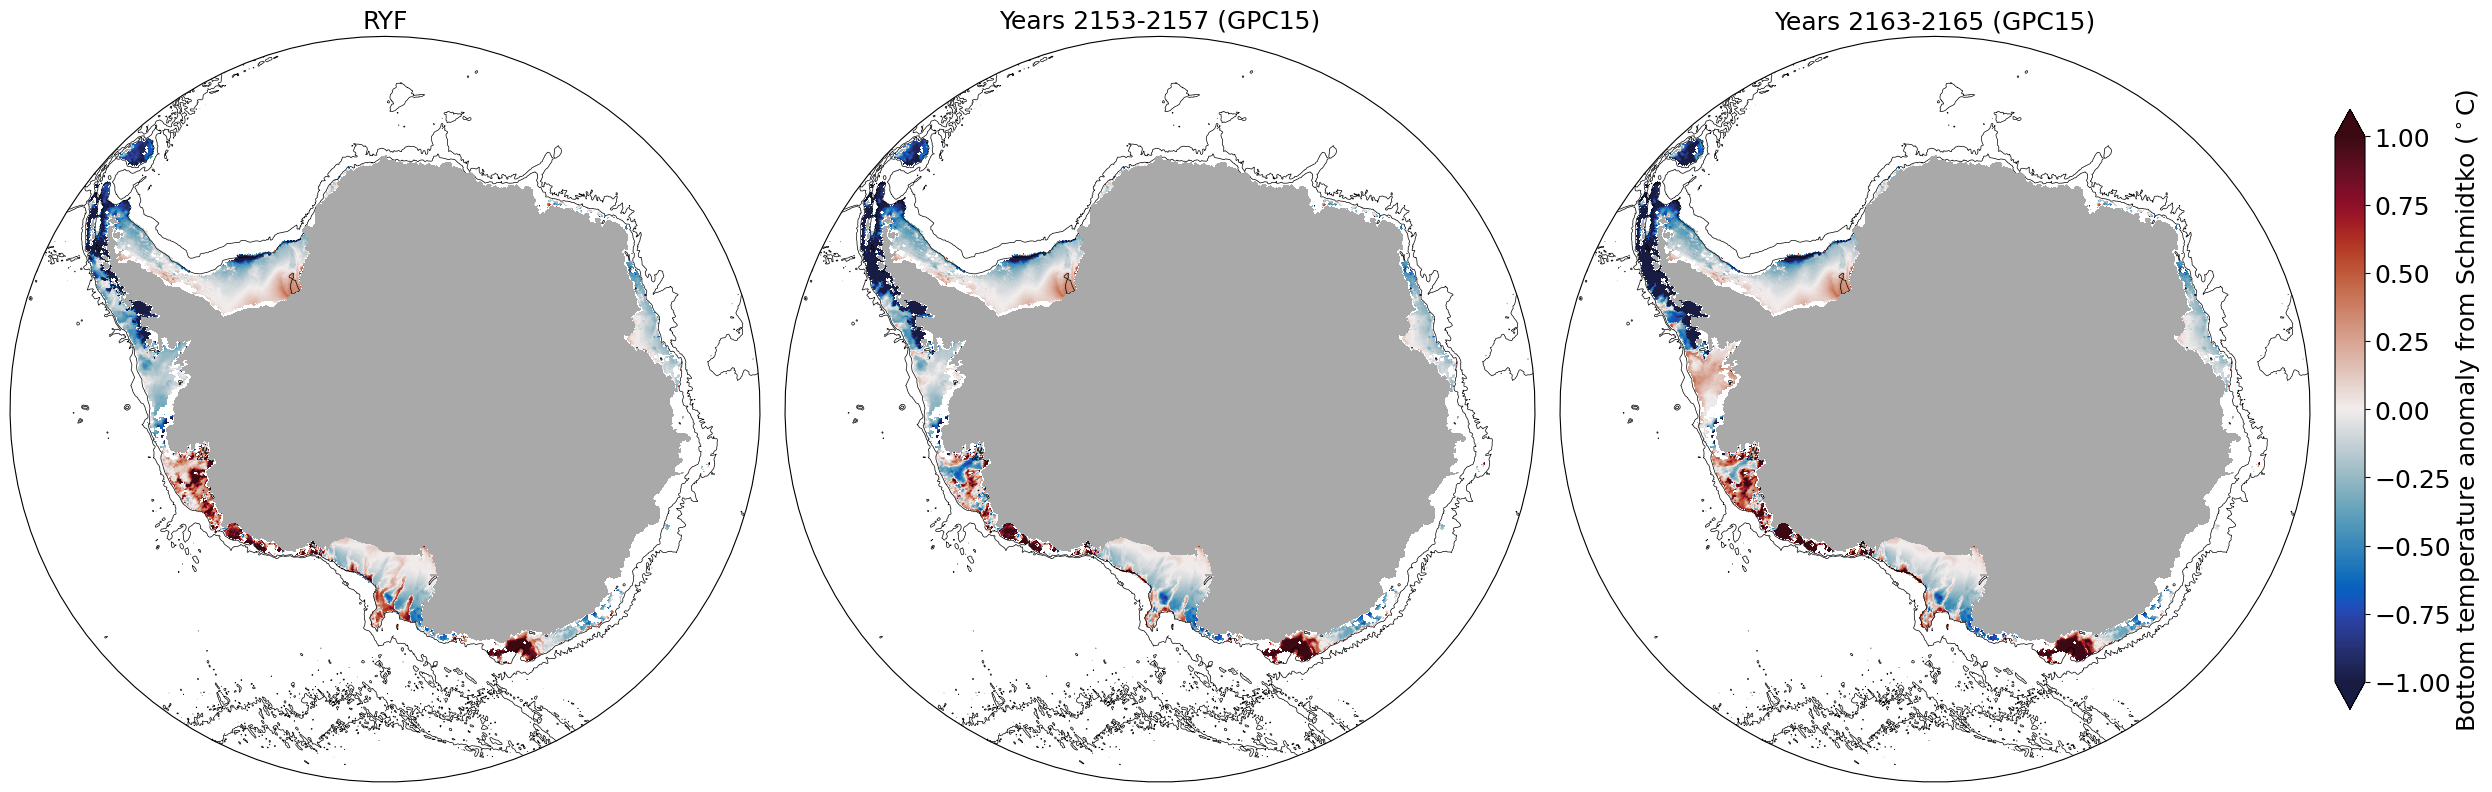

In [15]:
# compared to Schmidtko:

scale_max = 1
fontsize=18

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# Tfreezing_insituS
# setup stereo projection:
ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, bottom_temp_con-temp_Schmidtko, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('RYF',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Tfreezing_insituS
# setup stereo projection:
ax = fig.add_axes([0.31, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, bottom_temp_basal_53_57-temp_Schmidtko, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Years 2153-2157 (GPC15)',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Tfreezing_zeroS
ax = fig.add_axes([0.62, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, bottom_temp_basal_63_65-temp_Schmidtko, norm = norm, 
                   cmap = cmocean.balance,transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Years 2163-2165 (GPC15)',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Bottom temperature anomaly from Schmidtko ($^\circ$C)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

## Maps of SST anomaly:

In [ ]:
start_time='2155-01-01'
end_time='2169-12-31'

temp_con = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(st_ocean=0, method='nearest')
temp_con = temp_con.mean('time').load()

start_time='2155-01-01'
end_time='2159-12-31'

temp_basal_55_59 = cc.querying.getvar(basal, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_basal_55_59 = temp_basal_55_59.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(st_ocean=0, method='nearest')
temp_basal_55_59 = temp_basal_55_59.mean('time').load()

start_time='2165-01-01'
end_time='2169-12-31'

temp_basal_65_69 = cc.querying.getvar(basal, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_basal_65_69 = temp_basal_65_69.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(st_ocean=0, method='nearest')
temp_basal_65_69 = temp_basal_65_69.mean('time').load()

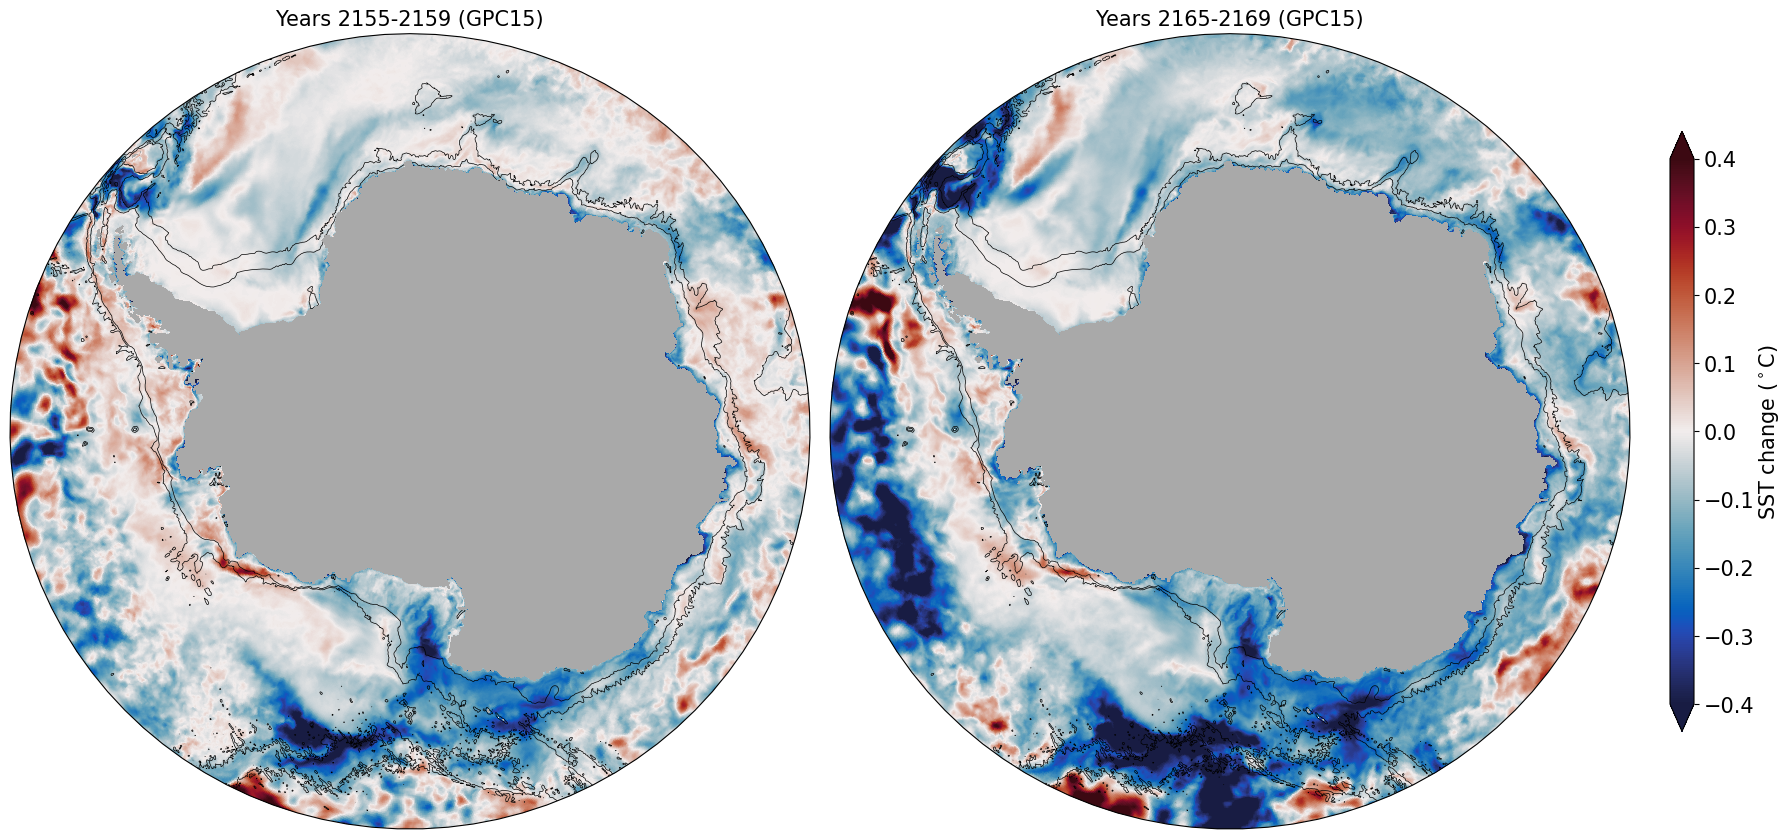

In [9]:
# compared to RYF:

scale_max = .4

fig  = plt.figure(1, figsize = (20,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# Tfreezing_insituS
# setup stereo projection:
ax = fig.add_axes([0.1, 0.0, 0.4, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(temp_con.xt_ocean, temp_con.yt_ocean, temp_basal_55_59-temp_con, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Years 2155-2159 (GPC15)',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Tfreezing_zeroS
ax = fig.add_axes([0.51, 0.0, 0.4, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(temp_con.xt_ocean, temp_con.yt_ocean, temp_basal_65_69-temp_con, norm = norm, 
                   cmap = cmocean.balance,transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Years 2165-2169 (GPC15)',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'SST change ($^\circ$C)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

## Timeseries of depth integrated salinity on shelf:

In [6]:
# shelf masking:
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf_mask = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean']
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_map = np.nan_to_num(shelf_mask)
shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
# Multiply the variable with the mask, we need to account for the shape of the mask. 
# The mask uses a northern cutoff of 59S.
shelf_mask = shelf_mask.sel(yt_ocean=lat_slice)

In [7]:
# thickness area for depth averaging (not time varying):

temp_con = cc.querying.getvar(control,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time))
# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(control, 'st_edges_ocean', master_session, start_time=start_time, end_time=end_time, n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean':temp_con.yt_ocean,'xt_ocean':temp_con.xt_ocean}, axis=[1,2])

# adjust edges at bottom for partial thickness:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
st_edges_with_partial = st_edges_array.where(st_edges_array<ht, other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(control, 'st_ocean', master_session, n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

In [8]:
# area for area averaging:

area_t = cc.querying.getvar(control,'area_t',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_t = area_t.sel(yt_ocean=lat_slice)
area_t = area_t * shelf_mask

#area_sum = area_t.sum('xt_ocean').sum('yt_ocean')


In [9]:
volume = area_t*thickness
volume = volume.load()
volume_sum = volume.sum()
volume_sum = volume_sum.load()

In [10]:
start_time='2150-01-01'
end_time='2165-12-31'

salt_con = cc.querying.getvar(control, 'salt', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_con = salt_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
# this is really slow for monthly data, so first compute annual means:
salt_con = salt_con.groupby('time.year').mean('time')
# shelf masking:
salt_con = salt_con*shelf_mask
# area and depth averaging on the shelf:
salt_con = (salt_con*volume).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/volume_sum
salt_con = salt_con.load()                                              

salt_basal = cc.querying.getvar(basal, 'salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_basal = salt_basal.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
salt_basal = salt_basal.groupby('time.year').mean('time')
# shelf masking:
salt_basal = salt_basal*shelf_mask
# area and depth averaging on the shelf:
salt_basal = (salt_basal*volume).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/volume_sum
salt_basal = salt_basal.load()                                               


2023-01-13 09:33:56,510 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 11.92 GiB -- Worker memory limit: 17.89 GiB
2023-01-13 09:34:50,791 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 12.22 GiB -- Worker memory limit: 17.89 GiB
2023-01-13 09:35:06,556 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

([<matplotlib.axis.YTick at 0x154bde400fa0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

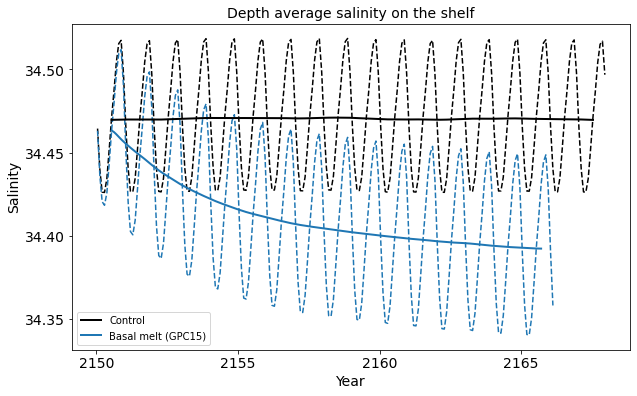

In [14]:
fontsize=14
plt.figure(figsize=(10,6))

salt_con.plot(color='k',linestyle='--')
salt_basal.plot(linestyle='--')
salt_con.rolling(time = 12, center = True).mean('time').plot(label='Control',linewidth=2,color='k')
salt_basal.rolling(time = 12, center = True).mean('time').plot(label='Basal melt (GPC15)',linewidth=2,color='C0')
plt.legend()
plt.title('Depth average salinity on the shelf',fontsize=fontsize)
plt.xlabel('Year',fontsize=fontsize)
plt.ylabel('Salinity',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.yticks([34.35,34.4,34.45,34.5])

## Timeseries of depth integrated temperature on shelf:

In [ ]:
start_time='2150-01-01'
end_time='2165-12-31'

temp_con = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
# This depth slice includes everything south of the 1000m isobath:
temp_con = temp_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(st_ocean=slice(0,2500))
# this is really slow for monthly data, so first compute annual means:
temp_con = temp_con.groupby('time.year').mean('time')
# shelf masking:
temp_con = temp_con*shelf_mask
# area and depth averaging on the shelf:
temp_con = (temp_con*volume).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/volume_sum
temp_con = temp_con.load()                         

temp_basal = cc.querying.getvar(basal, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_basal = temp_basal.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(st_ocean=slice(0,2500))
# this is really slow for monthly data, so first compute annual means:
temp_basal = temp_basal.groupby('time.year').mean('time')
# shelf masking:
temp_basal = temp_basal*shelf_mask
# area and depth averaging on the shelf:
temp_basal = (temp_basal*volume).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/volume_sum
temp_basal = temp_basal.load()                                               

In [ ]:
fontsize=14
plt.figure(figsize=(10,6))

temp_con.plot(label='Control',color='k')
temp_basal.plot(label='Basal melt (GPC15)')
plt.legend()
plt.title('Depth average temperature on the shelf',fontsize=fontsize)
plt.xlabel('Year',fontsize=fontsize)
plt.ylabel('Temperature',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
#plt.yticks([34.35,34.4,34.45,34.5])

## Timeseries of bottom temperature in Amundsen:

In [13]:
start_time='2150-01-01'
end_time='2167-12-31'

lon_slice  = slice(-115,-100)

temp_con = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# shelf masking:
temp_con = temp_con*shelf_mask
# select out bottom values:
depth_array = temp_con * 0 + temp_con.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)
temp_con = temp_con.where(depth_array.st_ocean >= max_depth)
temp_con = temp_con.sum(dim = 'st_ocean')
temp_con = temp_con.load()
# area averaging:
area_t = area_t.sel(xt_ocean=lon_slice)
area_sum = area_t.sum()
temp_con = (temp_con*area_t).sum('xt_ocean').sum('yt_ocean')/area_sum
temp_con = temp_con.load()                         

temp_basal = cc.querying.getvar(basal, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_basal = temp_basal.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# shelf masking:
temp_basal = temp_basal*shelf_mask
# select out bottom values:
temp_basal = temp_basal.where(depth_array.st_ocean >= max_depth)
temp_basal = temp_basal.sum(dim = 'st_ocean')
temp_basal = temp_basal.load()
# area averaging:
temp_basal = (temp_basal*area_t).sum('xt_ocean').sum('yt_ocean')/area_sum
temp_basal = temp_basal.load() 

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice 

<xarray.DataArray 'CT' ()>
array(-0.80844115)

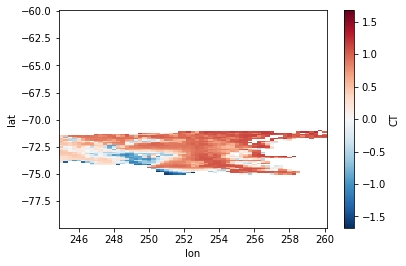

In [14]:
# load Schmidtko data for comparison:
filepath = '/g/data/v45/rm2389/Schmidtko_Observations/AASW_Temp_Salt.nc'
Schmidtko_data = xr.open_dataset(filepath)
temp_Schmidtko = Schmidtko_data.CT
temp_Schmidtko.sel(lon=slice(-115+360,-100+360)).plot()
# not proper area weighted mean:
temp_Schmidtko = temp_Schmidtko.mean('lon').mean('lat')
temp_Schmidtko

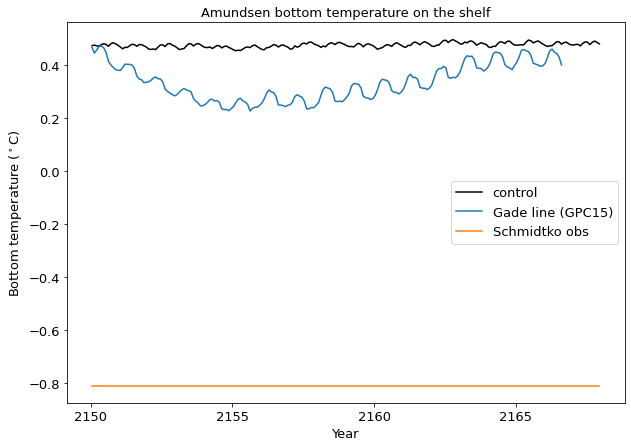

In [15]:
plt.figure(figsize=(10,7))

fontsize=13
temp_con.plot(label='control',color='k')
temp_basal.plot(label='Gade line (GPC15)')
plt.plot(temp_con.time,temp_con*0 + temp_Schmidtko,label='Schmidtko obs')
plt.legend(fontsize=fontsize)
plt.title('Amundsen bottom temperature on the shelf',fontsize=fontsize)
plt.ylabel(r'Bottom temperature ($^\circ$C)',fontsize=fontsize);
plt.xlabel(r'Year',fontsize=fontsize);
plt.tick_params(labelsize=fontsize)

## Timeseries of bottom temperature in east Ross:

In [16]:
start_time='2150-01-01'
end_time='2167-12-31'

lon_slice  = slice(-175,-140)

temp_con = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# shelf masking:
temp_con = temp_con*shelf_mask
# select out bottom values:
depth_array = temp_con * 0 + temp_con.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)
temp_con = temp_con.where(depth_array.st_ocean >= max_depth)
temp_con = temp_con.sum(dim = 'st_ocean')
temp_con = temp_con.load()
# area averaging
area_t = cc.querying.getvar(control,'area_t',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_t = area_t * shelf_mask
area_t = area_t.sel(xt_ocean=lon_slice).sel(yt_ocean=lat_slice)
area_sum = area_t.sum()
temp_con = (temp_con*area_t).sum('xt_ocean').sum('yt_ocean')/area_sum
temp_con = temp_con.load()                         

temp_basal = cc.querying.getvar(basal, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_basal = temp_basal.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# shelf masking:
temp_basal = temp_basal*shelf_mask
# select out bottom values:
temp_basal = temp_basal.where(depth_array.st_ocean >= max_depth)
temp_basal = temp_basal.sum(dim = 'st_ocean')
temp_basal = temp_basal.load()
# area averaging:
temp_basal = (temp_basal*area_t).sum('xt_ocean').sum('yt_ocean')/area_sum
temp_basal = temp_basal.load() 

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice 

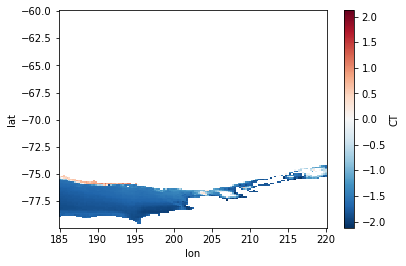

In [17]:
# load Schmidtko data for comparison:
filepath = '/g/data/v45/rm2389/Schmidtko_Observations/AASW_Temp_Salt.nc'
Schmidtko_data = xr.open_dataset(filepath)
temp_Schmidtko = Schmidtko_data.CT
temp_Schmidtko.sel(lon=slice(-175+360,-140+360)).plot()
# not proper area weighted mean:
temp_Schmidtko = temp_Schmidtko.mean('lon').mean('lat')

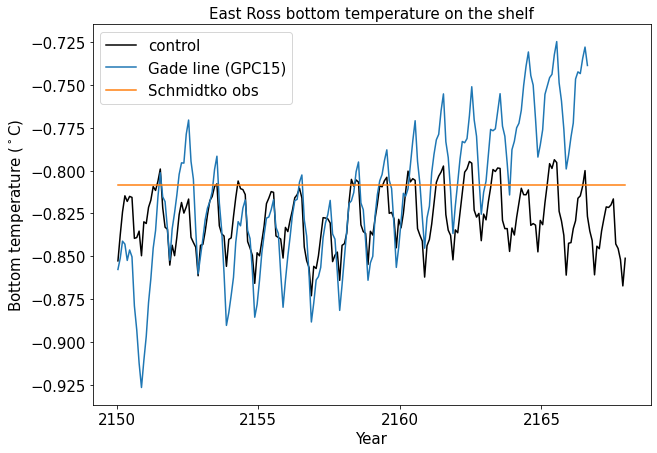

In [18]:
plt.figure(figsize=(10,7))

fontsize=15
temp_con.plot(label='control',color='k')
temp_basal.plot(label='Gade line (GPC15)')
plt.plot(temp_con.time,temp_con*0 + temp_Schmidtko,label='Schmidtko obs')
plt.legend(fontsize=fontsize)
plt.title('East Ross bottom temperature on the shelf',fontsize=fontsize)
plt.ylabel(r'Bottom temperature ($^\circ$C)',fontsize=fontsize);
plt.xlabel(r'Year',fontsize=fontsize);
plt.tick_params(labelsize=fontsize)